# REQUIRED LIBRARIES

In [ ]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import networkx as nx

import numpy as np
import pandas as pd

## Hub Location Problem in a Transportation Network

A distribution company aims to optimize the location of its distribution centers (hubs) to serve a set of client nodes (representing stores or warehouses). The company has a set of potential locations for the distribution centers (hubs), and it must decide which of these hubs to open and how to assign each client node to one of these hubs. The goal is to minimize the operational and transportation costs while respecting certain capacity constraints and the maximum number of hubs that can be opened.

Open a Hub?: For each potential hub, decide whether it should be opened or not.   
Assign a Node to a Hub?: For each client node, decide which hub will be responsible for supplying it.

## Sets

$N$ = set of nodes in the network (A, B, C, ..., T)  
$H \subseteq N$ = set of nodes that are potential locations for hubs  
$E \subseteq N \times H$ = set of possible connections between nodes and hubs

## Parameters

$f_h$ = fixed cost for establishing a hub at node $h$, $\forall h \in H$  
$c_{ij}$ = transportation cost between nodes $i$ and $j$, $\forall (i, j) \in N \times H$  
$d_i$ = demand at node $i$, $\forall i \in N$  
$u_h$ = capacity of the hub at node $h$, $\forall h \in H$  
$max_hubs$ = maximum number of hubs that can be selected

## Decision Variables

$y_h \in \{0, 1\}$ = binary variable indicating whether node $h$ is selected as a hub ($1$) or not ($0$), $\forall h \in H$  
$x_{ij} \in \{0, 1\}$ = binary variable indicating whether node $i$ is assigned to hub $j$ ($1$) or not ($0$), $\forall i \in N, \forall j \in H$

In [2]:
# Define the Network Data

# Define the sets of nodes and edges
nodes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T']

# Define the cost of establishing a distribution center at each node
fixed_costs = {
    'A': 100, 'B': 150, 'C': 120, 'D': 200, 'E': 150, 'F': 50, 'G': 170,
    'H': 180, 'I': 130, 'J': 200, 'K': 220, 'L': 250, 'M': 160, 'N': 130,
    'O': 140, 'P': 160, 'Q': 180, 'R': 210, 'S': 170, 'T': 190
}

# Define the transportation costs between nodes
transport_costs = {
    ('A', 'B'): 20, ('A', 'C'): 50, ('A', 'D'): 40, ('A', 'E'): 30, ('A', 'F'): 60, 
    ('A', 'G'): 70, ('B', 'C'): 15, ('B', 'D'): 35, ('B', 'E'): 60, ('B', 'F'): 40, 
    ('B', 'G'): 50, ('C', 'D'): 30, ('C', 'E'): 25, ('C', 'F'): 45, ('C', 'G'): 35, 
    ('D', 'E'): 40, ('D', 'F'): 55, ('D', 'G'): 50, ('E', 'F'): 25, ('E', 'G'): 30, 
    ('F', 'G'): 40, ('H', 'I'): 20, ('H', 'J'): 40, ('H', 'K'): 30, ('H', 'L'): 50,
    ('I', 'J'): 25, ('I', 'K'): 35, ('I', 'L'): 45, ('J', 'K'): 50, ('J', 'L'): 60,
    ('K', 'L'): 40, ('L', 'M'): 35, ('M', 'N'): 45, ('N', 'O'): 30, ('O', 'P'): 60, 
    ('P', 'Q'): 40, ('Q', 'R'): 55, ('R', 'S'): 25, ('S', 'T'): 35
}

# Define the demand at each node
demands = {
    'A': 50, 'B': 25, 'C': 15, 'D': 40, 'E': 40, 'F': 10, 'G': 15, 
    'H': 20, 'I': 35, 'J': 30, 'K': 35, 'L': 40, 'M': 65, 'N': 50, 
    'O': 55, 'P': 60, 'Q': 65, 'R': 30, 'S': 75, 'T': 80
}

# Define the capacity of each potential distribution center
capacities = {
    'A': 90, 'B': 75, 'C': 150, 'D': 130, 'E': 100, 'F': 110, 'G': 80, 
    'H': 95, 'I': 70, 'J': 90, 'K': 60, 'L': 140, 'M': 160, 'N': 150,
    'O': 130, 'P': 110, 'Q': 105, 'R': 140, 'S': 125, 'T': 70
}

candidate_hubs = nodes

#Define a maximum number of hubs to be selected
max_hubs = 3

# Create Pyomo Model
model = ConcreteModel()

# Define sets
model.N = Set(initialize=nodes)
model.H = Set(initialize=candidate_hubs)

# Define parameters
model.f = Param(model.H, initialize=fixed_costs)
model.c = Param(model.N, model.H, initialize=transport_costs, default=9999)
model.d = Param(model.N, initialize=demands)
model.u = Param(model.H, initialize=capacities)
# Define auxiliary variables for cycle elimination
model.u = Var(model.N, within=NonNegativeIntegers)

# Define decision variables
model.y = Var(model.H, within=Binary)
model.x = Var(model.N, model.H, within=Binary)

'pyomo.core.base.param.IndexedParam'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().


## Objective Function

Minimize the total cost, which is the sum of the fixed costs of opening hubs and the transportation costs between nodes and hubs:

$$
\text{Minimize} \quad Z = \sum_{h \in H} f_h y_h + \sum_{i \in N} \sum_{j \in H} c_{ij} x_{ij}
$$


In [3]:
# Objective function
def objective_rule(model):
    return sum(model.f[j] * model.y[j] for j in model.H) + sum(model.c[i, j] * model.x[i, j] for i in model.N for j in model.H)
model.obj = Objective(rule=objective_rule, sense=minimize)


## Constraints

1. **Single Node Assignment:**
   Each node must be assigned to exactly one hub:

   $$
   \sum_{j \in H} x_{ij} = 1 \quad \forall i \in N
   $$

2. **Hub Capacity:**
   The total demand assigned to each hub must not exceed its capacity:

   $$
   \sum_{i \in N} d_i x_{ij} \leq u_h y_h \quad \forall h \in H
   $$

3. **Hub Activation:**
   A node can be assigned to a hub only if the hub is open:

   $$
   x_{ij} \leq y_h \quad \forall i \in N, \forall j \in H
   $$

4. **Maximum Number of Hubs:**
   The total number of hubs selected must not exceed the maximum allowed:

   $$
   \sum_{h \in H} y_h \leq max_hubs
   $$

5. **No Self-Assignment:**
   No node can be assigned to itself as a hub :

   $$
   x_{ii} = 0 \quad \forall i \in N
   $$

In [4]:
# Constraints
def single_assignment_rule(model, i):
    return sum(model.x[i, j] for j in model.H) == 1
model.single_assignment = Constraint(model.N, rule=single_assignment_rule)

def capacity_rule(model, j):
    return sum(model.d[i] * model.x[i, j] for i in model.N) <= model.u[j] * model.y[j]
model.capacity = Constraint(model.H, rule=capacity_rule)

def open_hub_rule(model, i, j):
    return model.x[i, j] <= model.y[j]
model.open_hub = Constraint(model.N, model.H, rule=open_hub_rule)

def no_self_assign_rule(model, i, j):
    return model.x[i, j] <= 1 - model.x[i, i]
model.no_self_assign = Constraint(model.N, model.H, rule=no_self_assign_rule)


def max_hubs_rule(model):
    return sum(model.y[j] for j in model.H) <= max_hubs
model.max_hubs = Constraint(rule=max_hubs_rule)

# Solving the model


In [5]:

# Create a solver
solver = SolverFactory('gurobi')

# Solve the model
results = solver.solve(model, tee=True)

Set parameter Username
Set parameter LicenseID to value 2597254
Academic license - for non-commercial use only - expires 2025-12-09
Read LP format model from file C:\Users\juanj\AppData\Local\Temp\tmp_eh_osm9.pyomo.lp
Reading time = 0.01 seconds
x1: 821 rows, 440 columns, 2000 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13620H, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 821 rows, 440 columns and 2000 nonzeros
Model fingerprint: 0x3453c746
Model has 20 quadratic constraints
Variable types: 0 continuous, 440 integer (420 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+01, 8e+01]
  Objective range  [2e+01, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
Presolve removed 420 rows and 20 columns
Presolve time: 0.0

# SOLUTION INTERPRETATION


In [6]:
# Display selected hubs
selected_hubs = [j for j in model.H if value(model.y[j]) > 0.5]
print("Selected Hubs:")
for hub in selected_hubs:
    print(f"Hub {hub} with cost {model.f[hub]}")

# Display node assignments
model.N = model.N - selected_hubs # Remove hubs from the set of nodes
assignments = {i: j for i in model.N for j in model.H if value(model.x[i, j]) > 0.5}
print("\nNode Assignments to Hubs:")
for node, hub in assignments.items():
    print(f"Node {node} assigned to Hub {hub}")

Selected Hubs:
Hub G with cost 170
Hub L with cost 250
Hub O with cost 140
'pyomo.core.base.set.OrderedScalarSet'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.set.SetDifference_OrderedSet'>). This is usually
indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().

Node Assignments to Hubs:
Node A assigned to Hub G
Node B assigned to Hub G
Node C assigned to Hub G
Node D assigned to Hub G
Node E assigned to Hub G
Node F assigned to Hub G
Node H assigned to Hub L
Node I assigned to Hub L
Node J assigned to Hub L
Node K assigned to Hub L
Node M assigned to Hub O
Node N assigned to Hub O
Node P assigned to Hub O
Node Q assigned to Hub L
Node R assigned to Hub O
Node S assigned to Hub O
Node T assigned to Hub O


# NETWORK 

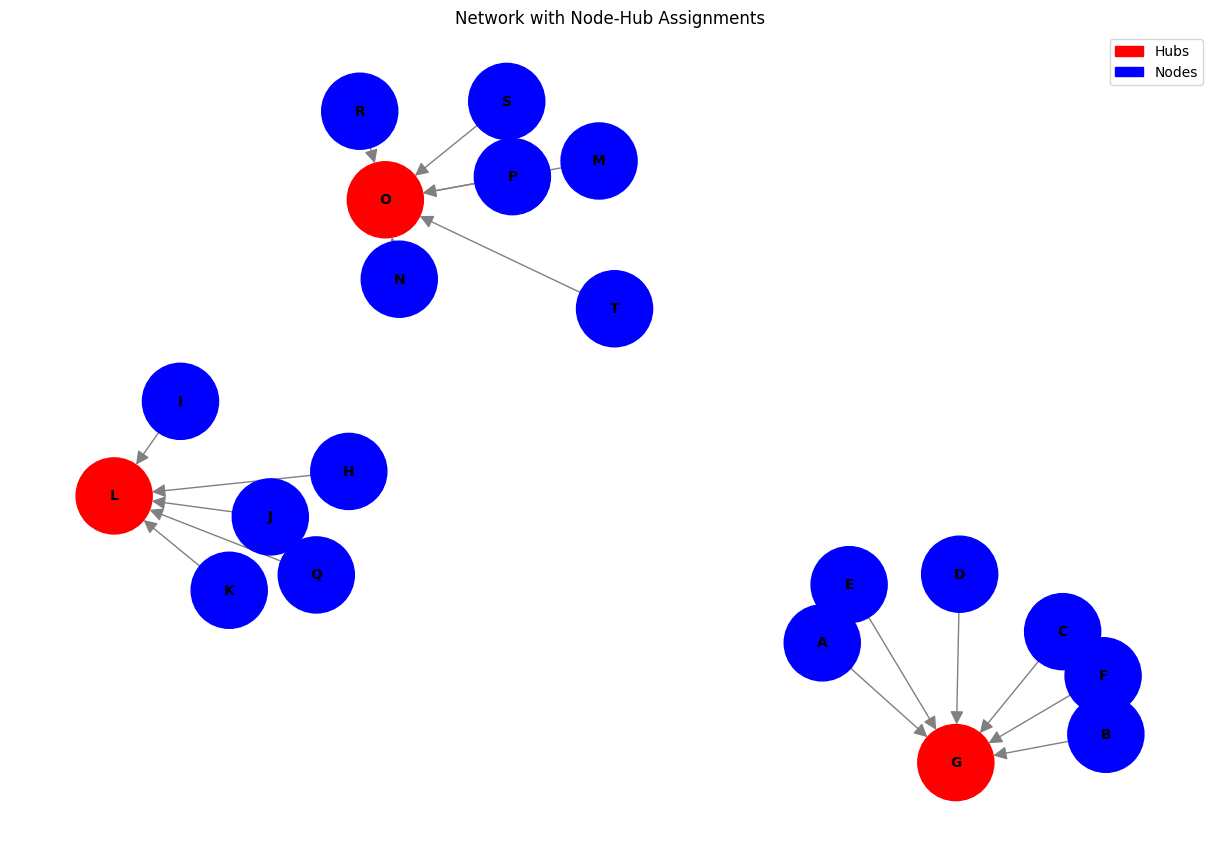

In [7]:

# Node to hub assignments obtained from the model

assignments = {i: j for i in model.N for j in model.H if value(model.x[i, j]) > 0.5}

# Create the directed graph
G = nx.DiGraph()

# Add nodes to the graph (nodes and hubs)
G.add_nodes_from(nodes)

# Add edges based on node to hub assignments
for node, hub in assignments.items():
    G.add_edge(node, hub)

# Color the nodes based on whether they are hubs or not (hubs red, nodes blue)
colors = ['r' if node in assignments.values() else 'b' for node in nodes]

# Use a layout for better node positioning
pos = nx.spring_layout(G, k=0.5, iterations=50)

# Draw the graph with only the relevant connections
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=3000, font_size=10, font_weight='bold', edge_color='gray', arrowsize=20)

# Create a custom legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Hubs')
blue_patch = mpatches.Patch(color='blue', label='Nodes')
plt.legend(handles=[red_patch, blue_patch], loc='best')

plt.title("Network with Node-Hub Assignments")
plt.show()

# 2. PROBLEM DEFINITION                                                                    
The goal of this problem is to optimize the allocation of water to a set of parcels of land to maximize the agricultural yield, while considering the costs of water and ensuring fairness in the distribution of water across parcels. The objective is to allocate a fixed amount of water across multiple parcels, taking into account the water needs and limitations of each parcel, as well as the cost associated with using water.

#  DEFININING SETS, PARAMETERS AND VARIABLES
## Sets

$P$ = set of parcels (1, 2, 3, 4, 5)  

## Parameters

$k_i$ = water yield factor for parcel $i$, $\forall i \in P$  
$\alpha$ = nonlinear exponent for the yield function  
$\text{cost\_water}$ = cost per unit of water  
$\text{total\_water\_available}$ = total available water  
$\text{min\_water}_i$ = minimum water requirement for parcel $i$  
$\text{max\_water}_i$ = maximum water allowance for parcel $i$  
$\text{d\_max}$ = maximum allowed difference between water allocation of any two parcels                  
$\text{min\_yield}$ = minimum expected agricultural yield



## Decision Variables

$x_i$ = amount of water allocated to parcel $i$, $\forall i \in P$


In [9]:
# Pyomo model
model = ConcreteModel()

# Set: Parcels
n_parcels = 5  # Number of parcels
model.Parcels = RangeSet(0, n_parcels - 1)

# Parameters
np.random.seed(42)  # Seed for reproducibility
model.k = Param(model.Parcels, initialize=lambda model, i: np.random.uniform(2, 5))  # Water yield
model.alpha = Param(initialize=0.6)  # Nonlinear exponent for yield
model.water_cost = Param(initialize=0.1)  # Cost per unit of water
model.total_water_available = Param(initialize=400)  # Total available water
model.d_max = Param(initialize=20)  # Maximum allowed difference
model.min_yield = Param(initialize=200)  # Parámetro de rendimiento mínimo esperado


#initial values for min_water and max_water
manual_min_water = {0: 55, 1: 78, 2: 65, 3: 89, 4: 73}
manual_max_water = {0: 160, 1: 185, 2: 170, 3: 190, 4: 175}

# Adjusting values randomly within a small range
adjustment_range = 10  # Define the range for random adjustment
min_water = {i: max(50, manual_min_water[i] + np.random.uniform(-adjustment_range, adjustment_range)) for i in range(n_parcels)}
max_water = {i: min(200, manual_max_water[i] + np.random.uniform(-adjustment_range, adjustment_range)) for i in range(n_parcels)}

# Assign adjusted values to the model
model.min_water = Param(model.Parcels, initialize=min_water)
model.max_water = Param(model.Parcels, initialize=max_water)
model.d_max = Param(initialize=20)  # Maximum allowed difference
model.diff = Var(model.Parcels, model.Parcels, bounds=(0, None))  # Difference between parcels

# Decision variables
model.x = Var(model.Parcels, bounds=lambda model, i: (model.min_water[i], model.max_water[i]))
model.diff = Var(model.Parcels, model.Parcels, bounds=(0, None))  # Difference between parcels

'pyomo.core.base.param.ScalarParam'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.param.ScalarParam'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.var.IndexedVar'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.var.IndexedVar'>). This is usually indicative of
a modelling error. To avoid this warning, use block.del_component() and
block.add_component().



## Objective Function

Maximize the total agricultural yield minus the cost of water:

\begin{align*}
\underset{x_i}{\max} & \quad \sum_{i \in P} k_i x_i^\alpha - \text{cost\_water} \sum_{i \in P} x_i
\end{align*} 


In [10]:

# Objective function: Maximize yield minus water cost
def objective_rule(model):
    return sum(model.k[i] * model.x[i]**model.alpha for i in model.Parcels) - model.water_cost * sum(model.x[i] for i in model.Parcels)
model.Objective = Objective(rule=objective_rule, sense=maximize)

## Constraints

### Total Water Constraint

The total amount of water allocated to all parcels cannot exceed the available water:

\begin{align*}
\sum_{i \in P} x_i \leq \text{total\_water\_available}
\end{align*}

### Minimum and Maximum Water Allocation

Water allocated to each parcel must lie between the minimum and maximum limits for each parcel:

\begin{align*}
\text{min\_water}_i \leq x_i \leq \text{max\_water}_i \quad \forall i \in P
\end{align*}

### Difference Constraint

The difference in water allocation between any two parcels must be non-negative:

\begin{align*}
x_i - x_j \geq 0 \quad \forall i, j \in P
\end{align*}

### Maximum Allowed Difference

The difference in water allocation between any two parcels cannot exceed the maximum allowed difference:

\begin{align*}
|x_i - x_j| \leq \text{d\_max} \quad \forall i, j \in P
\end{align*}

### Minimum Expected Yield

The total agricultural yield must be greater than or equal to the minimum expected yield:

\begin{align*}
\sum_{i \in P} k_i \cdot x_i^\alpha \geq \text{min\_yield}
\end{align*}

In [11]:
# Total water allocated cannot exceed available water
def total_water_constraint_rule(model):
    return sum(model.x[i] for i in model.Parcels) <= model.total_water_available
model.TotalWaterConstraint = Constraint(rule=total_water_constraint_rule)

# Difference between water allocated to parcels
def difference_rule(model, i, j):
    return model.diff[i, j] >= model.x[i] - model.x[j]
model.Difference1 = Constraint(model.Parcels, model.Parcels, rule=difference_rule)

# Maximum allowed difference between parcels
def max_difference_rule(model, i, j):
    return model.diff[i, j] <= model.d_max
model.Difference2 = Constraint(model.Parcels, model.Parcels, rule=max_difference_rule)

# Minimum Expected Yield Constraint
def minimum_yield_rule(model):
    return sum(model.k[i] * model.x[i]**model.alpha for i in model.Parcels) >= model.min_yield
model.MinimumYield = Constraint(rule=minimum_yield_rule)

# SOLVING THE MODEL

In [12]:
# Solve the model
solver = SolverFactory("ipopt")
results = solver.solve(model, tee=True)

# Display results

if results.solver.status == SolverStatus.ok and results.solver.termination_condition == TerminationCondition.optimal:
    print("\nOptimal solution found:")
    print(f"Adjusted min_water: {min_water}")
    print(f"Adjusted max_water: {max_water}")
    for i in model.Parcels:
        print(f"Parcel {i + 1}: Water allocated = {model.x[i]():.2f} m³")
    total_yield = sum(model.k[i] * model.x[i]()**model.alpha for i in range(n_parcels))
    total_cost = model.water_cost * sum(model.x[i]() for i in range(n_parcels))
    print(f"\nTotal yield: {total_yield:.2f} units")
    print(f"Total water cost: {total_cost:.2f} monetary units")
    print(f"Net benefit: {total_yield - total_cost:.2f} units")
else:
    print("\nOptimal solution not found.")

Ipopt 3.14.16: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      105
Number of nonzeros in Lagrangian Hessian.............:        5

Total number of variables............................:       30
                     variables with only lower bounds:       25
                variables with lower and upper bounds:        5
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number

# INTERPRETATION
The solution to the water allocation problem effectively distributes the available water resources among the five parcels to maximize the net benefit while meeting all constraints. Parcel 1 receives 71.02 m³ of water, Parcel 2 receives 88.47 m³, Parcel 3 receives 72.32 m³, Parcel 4 receives 91.02 m³, and Parcel 5 receives 77.16 m³. This allocation ensures that the total water used (400 m³) does not exceed the available limit.

The total yield achieved from this allocation is 256.86 units, surpassing the minimum expected yield constraint of 200 units. The total water cost is 40.00 monetary units, resulting in a net benefit of 216.86 units. The solution also respects the constraints on minimum and maximum water allocation for each parcel and maintains the allowable differences in water distribution between parcels.

This outcome demonstrates an optimal balance between maximizing crop yield and minimizing costs, showcasing the model's ability to handle nonlinear relationships and resource constraints effectively.

# Plots

## Water allocation per parcel

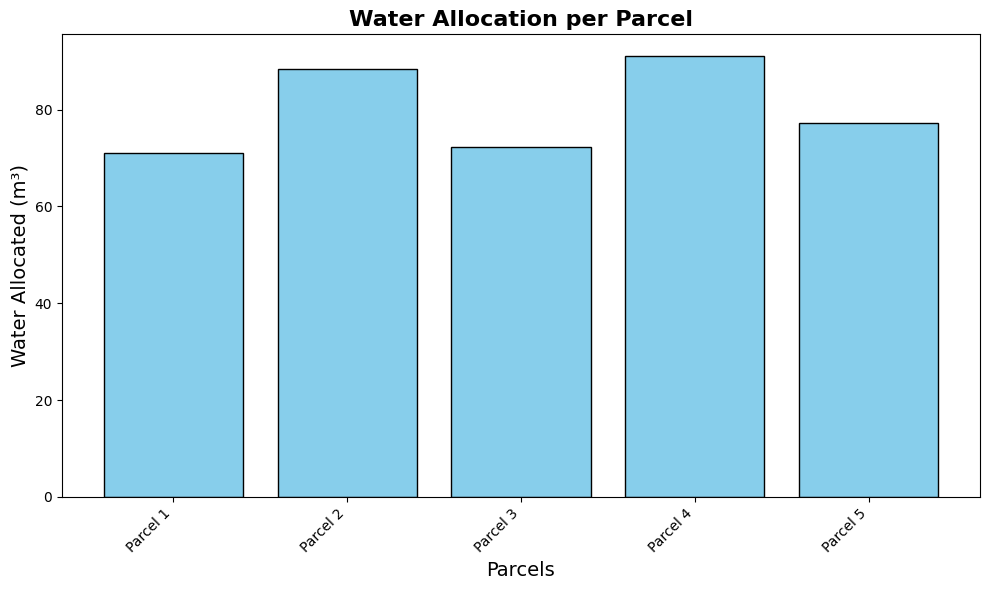

In [13]:

# Assuming model.Parcels and model.x are defined
parcels = list(model.Parcels)
water_allocated = [model.x[i]() for i in parcels]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar([f"Parcel {i+1}" for i in parcels], water_allocated, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel("Parcels", fontsize=14)
plt.ylabel("Water Allocated (m³)", fontsize=14)
plt.title("Water Allocation per Parcel", fontsize=16, fontweight='bold')

# Improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()


## Relation between water allocation and yield

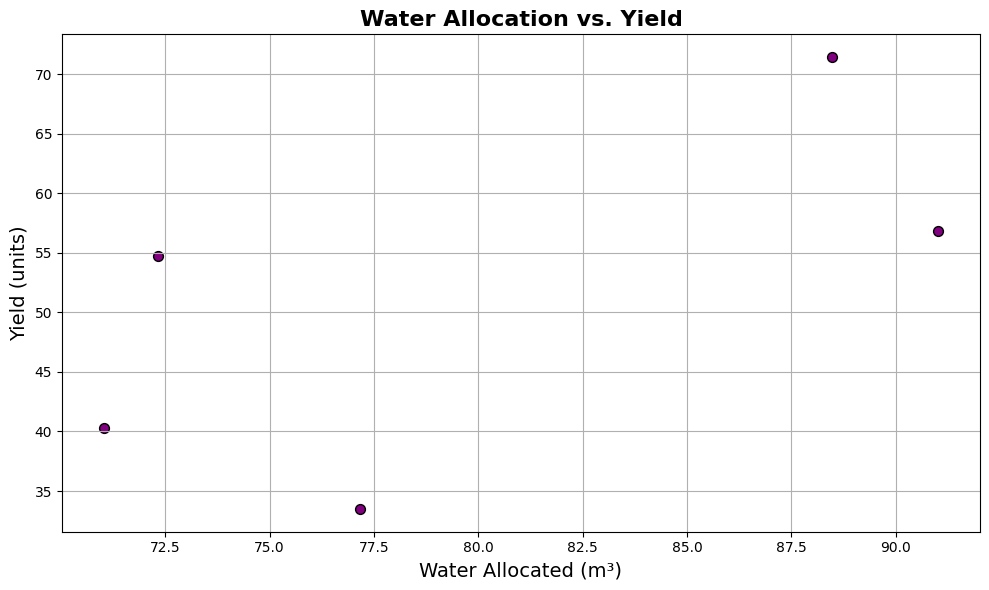

In [14]:
parcels = list(model.Parcels)
water_allocated = [model.x[i]() for i in parcels]
yields = [model.k[i] * model.x[i]()**model.alpha for i in parcels]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(water_allocated, yields, color='purple', s=50, edgecolor='black')

# Add labels and title
plt.xlabel("Water Allocated (m³)", fontsize=14)
plt.ylabel("Yield (units)", fontsize=14)
plt.title("Water Allocation vs. Yield", fontsize=16, fontweight='bold')

# Add grid and improve layout
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

## Total cost vs yield

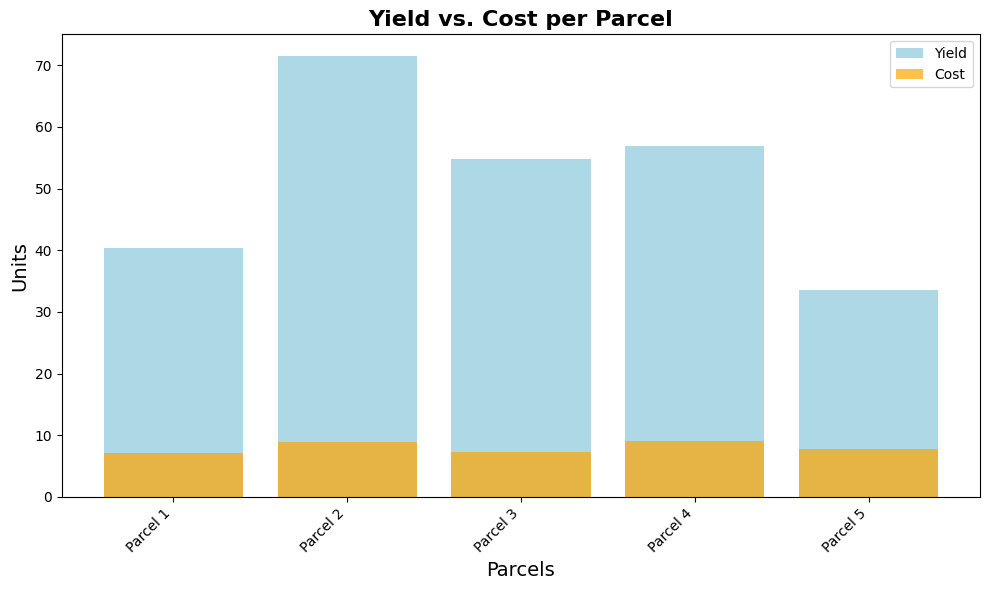

In [15]:
# Assuming model.Parcels, model.x, model.k, model.alpha, and model.water_cost are defined
parcels = list(model.Parcels)
yields = [model.k[i] * model.x[i]()**model.alpha for i in parcels]
costs = [model.water_cost * model.x[i]() for i in parcels]

# Create the bar plot
x = range(len(parcels))
plt.figure(figsize=(10, 6))
plt.bar(x, yields, color='lightblue', label="Yield")
plt.bar(x, costs, color='orange', label="Cost", alpha=0.7)

# Add labels and title
plt.xticks(x, [f"Parcel {i+1}" for i in parcels], rotation=45, ha='right')
plt.xlabel("Parcels", fontsize=14)
plt.ylabel("Units", fontsize=14)
plt.title("Yield vs. Cost per Parcel", fontsize=16, fontweight='bold')

# Add legend and improve layout
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()